# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. **Do not import anything else.**
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: 313296071_308147131

In [56]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [58]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

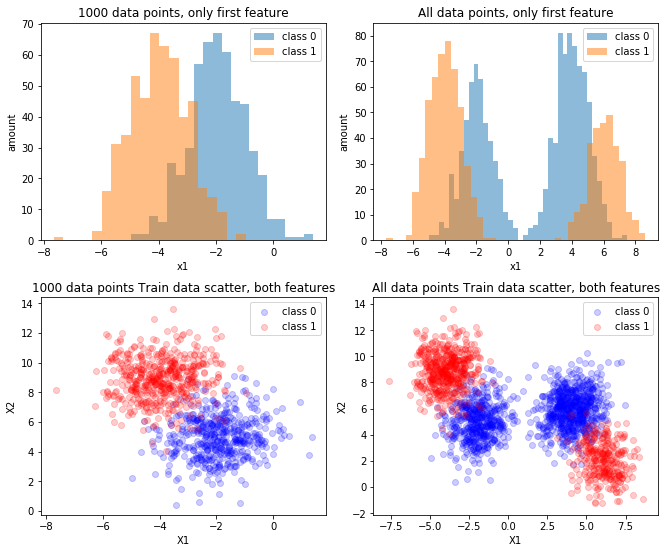

In [59]:
#### Your code here ####
plt.subplot(2,2,1)
plt.tight_layout(pad=4)

class0 = training_set.values[:1000,:][training_set.values[:1000, -1] == 0]
class1 = training_set.values[:1000,:][training_set.values[:1000, -1] == 1]
plt.hist(class0[:,0], bins = 20, alpha=0.5, label='class 0')
plt.hist(class1[:,0], bins = 20, alpha=0.5, label='class 1')
plt.xlabel("x1")
plt.ylabel("amount")
plt.title("1000 data points, only first feature")
plt.legend()


plt.subplot(2,2,2)
class0 = training_set.values[training_set.values[:,-1] == 0]
class1 = training_set.values[training_set.values[:,-1] == 1]
plt.hist(class0[:,0], bins = 40, alpha=0.5, label='class 0')
plt.hist(class1[:,0], bins = 40, alpha=0.5, label='class 1')
plt.xlabel("x1")
plt.ylabel("amount")
plt.title("All data points, only first feature")
plt.legend()


plt.subplot(2,2,3)
class0 = training_set.values[:1000, :][training_set.values[:1000, -1] == 0]
class1 = training_set.values[:1000, :][training_set.values[:1000, -1] == 1]
plt.scatter(class0[:,0],class0[:,1], color = 'b', alpha=0.2, label='class 0')
plt.scatter(class1[:,0], class1[:,1], color = 'r', alpha=0.2, label='class 1')
plt.title("1000 data points Train data scatter, both features")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()

plt.subplot(2,2,4)
class0 = training_set.values[training_set.values[:, -1] == 0]
class1 = training_set.values[training_set.values[:, -1] == 1]
plt.scatter(class0[:,0],class0[:,1], color = 'b', alpha=0.2, label='class 0')
plt.scatter(class1[:,0], class1[:,1], color = 'r', alpha=0.2, label='class 1')
plt.title("All data points Train data scatter, both features")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()

plt.show()

## Logistic Regression

(20 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [60]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.J_history = []
        # intialize first theta
        np.random.seed(self.random_state)
        self.theta = np.random.random(size=3)
        

    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """

        X = np.column_stack((np.ones(len(X)),X))  # add bias, ask in piaza
        EPSILON = 0.00000000001
        m = len(y) 
        mistake = 0

        for iteration in range(self.n_iter):
            hypo_funct = 1/(1 + np.exp((-1)*np.dot(X, self.theta)))   # calculate the hypothsis function

            sigma_calc = X.T.dot(hypo_funct - y)         # calculate the Sigma part of the GD function

            tmp_theta = self.theta - (self.eta*sigma_calc)        # finds trained theta 
            self.theta = tmp_theta                                 # update the original Theta into the trained one
            
            mistake = (np.dot(-y, np.log(hypo_funct + EPSILON)) - np.dot(1 - y, np.log(1 - hypo_funct + EPSILON)))/m

            self.J_history.append(mistake)   
        
        
            if (iteration > 1) and (abs(self.J_history[-2] - self.J_history[-1]) < self.eps):                          
                break
 
        
    
    def predict(self, X):
        """Return the predicted class label"""
        
        X = np.column_stack((np.ones(len(X)),X))
        prediction = 1/(1 + np.exp(-np.dot(X,self.theta)))

        return np.where(prediction > 0.5, 1, 0)
    
    def get_accuracy(self, X, y):
        prediction_array = self.predict(X)
        return len(prediction_array[prediction_array == y])/len(y)


## Cross Validation

(10 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [78]:
#### Your code here ####
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005] # leraning  rate
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001] # minimal cost change


        
def acuuracy(model, X_val_set, y_val_set):
    prediction_array = model.predict(X_val_set)

    return len(prediction_array[prediction_array == y_val_set])/len(y_val_set)

def k_foldCalc(k, data, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
    shuffeld_data = data
    np.random.shuffle(shuffeld_data)
    fold_indices = np.arange(0, len(shuffeld_data), int(len(shuffeld_data)/k))
    acuuracy_array = []

    for i in range(len(fold_indices)):
        loggi = LogisticRegressionGD(eta, n_iter, eps, random_state)
        
        if i < (len(fold_indices)-1):
            train_data = np.concatenate((shuffeld_data[:fold_indices[i]], shuffeld_data[fold_indices[i+1]:]))
            validation_set = shuffeld_data[fold_indices[i]:fold_indices[i+1]]
        else:
            train_data = shuffeld_data[:fold_indices[i]]
            validation_set = shuffeld_data[fold_indices[i]:]
            
        
        loggi.fit(train_data[:,:-1], train_data[:,-1])
        acuuracy_array.append(acuuracy(loggi, validation_set[:,:-1], validation_set[:,-1]))

    return np.mean(acuuracy_array)


In [79]:
allCombo = []
for eta in etas:
    for eps in epss:
        allCombo.append([eta,eps])
        
data = np.array(training_set.values)

cross = []
for combo in allCombo:
    cross.append(k_foldCalc(5, data, eps=combo[1], eta=combo[0]))

In [80]:
bestCombo = allCombo[cross.index(np.max(cross))]
print("Best combination: ")
print("Best eta: ", bestCombo[0])
print("Best eps: ", bestCombo[1])
print("Best accuracy: {}%".format( 100*cross[cross.index(np.max(cross))]))

Best combination: 
Best eta:  5e-05
Best eps:  1e-06
Best accuracy: 78.8%


## Normal distribution pdf

(5 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [81]:
#### Your code here ####
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    exp_power = (-1) * (((data-mu)**2)/(2*sigma))    
    fraction = np.sqrt(2*np.pi*sigma)
    return np.exp(exp_power)/fraction

## Expectation Maximization

(20 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [82]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps


    # initial guesses for parameters

    def init_params(self, data):
        """
        Initialize distribution params
        """
        self.w =  np.random.rand(self.k)
        
        self.w = np.column_stack(self.w / np.sum(self.w))
        data = np.split(np.sort(data), self.k)
        self.mu = np.column_stack(np.array([np.mean(part) for part in data]))
        self.sigma = np.column_stack(np.array([(np.std(part)**2) for part in data]))

        

    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        r = self.w * norm_pdf(data, self.mu, self.sigma)
        self.probability = np.row_stack(np.sum(r, axis = 1))
        return r/self.probability

    
    def maximization(self, data):
        """
        M step - updating distribution params
        """
        N = data.shape[0]
        respons =  self.expectation(data)
        self.w = np.sum(respons, axis = 0)/N      
        self.mu = np.sum(data * respons, axis =0)/(N * self.w)
        self.sigma = np.sum(((data-self.mu)**2) * respons, axis = 0) / (N * self.w)

        
    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params(data)
        prev_cost = 1e200
        curr_cost = 0
        data = np.row_stack(data)

        for i in range(self.n_iter):
            r = self.expectation(data)
            curr_cost = self.calc_cost(data)
            self.maximization(data)
            curr_cost = self.calc_cost(data)
            if ((prev_cost - curr_cost)< self.eps):
                break
            prev_cost = curr_cost

        
    def calc_cost(self, data):
        return np.sum(-np.log(self.probability))

    
    def get_dist_params(self):
        
        return self.w, self.mu, self.sigma
    



## Naive Bayes

(20 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [83]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, random_state=1):
        self.k = k
        self.random_state = random_state


    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        self.classes, self.classes_prior = np.unique(y, return_counts = True)
        self.classes_prior = self.classes_prior/len(y)

        num_of_features = X.shape[1]
        num_of_classes = self.classes.shape[0]
        
        self.ws = np.empty([num_of_classes, num_of_features, self.k])
        self.means = np.empty([num_of_classes, num_of_features, self.k])
        self.sigmas = np.empty([num_of_classes, num_of_features, self.k])
    
        X = np.column_stack([X,y])
        
        for i in range(num_of_classes):       # do it for each class 0/1
            for j in range(num_of_features):  # and for every feature
                relevent_data = X[X[:,-1] == self.classes[i]]  # get only data of same class
                relevent_data = relevent_data[:,j]             # only for this specifiec feature
                em = EM(k = self.k)
                em.fit(relevent_data)
                self.ws[i][j], self.means[i][j], self.sigmas[i][j] = em.get_dist_params()   #save dits params 

    
    
    def predict(self, X):
        """Return the predicted class label"""
        predictions = np.empty([self.classes.shape[0], X.shape[0]])
        for class_value in range(self.classes.shape[0]):
            prior = self.classes_prior[class_value]
            likelihood = self.get_likelihood(X, class_value)
            predictions[class_value] = prior * likelihood
        
        predictions = predictions[0] < predictions[1]
        predictions = predictions.astype(int)
        return predictions
    

    
    
    def get_likelihood(self, X, value_of_class):
        """
        returns the likelihood of intances according to class 
        """
        likelihood = 1
        for feature in range(X.shape[1]):
            probability = 0 
            
            for i in range(self.k):
                probability += self.ws[value_of_class][feature][i] * norm_pdf(X[:, feature], self.means[value_of_class][feature][i], self.sigmas[value_of_class][feature][i])
            
            likelihood *= probability
            
        return likelihood

    
    def get_accuracy(self, test_set, labels_test_set):
        prediction_array = self.predict(test_set)
        acc = (prediction_array == labels_test_set)
        acc = acc.astype(int)
        return np.sum(acc)/acc.shape[0]

## Model evaluation

(10 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points

Logistic Regression: (1000 training data points, 500 test set data points)
Training accuracy: 96.5%
Test accuracy: 93.8%

Naive Bayes: (1000 training data points, 500 test set data points)
Training accuracy: 96.8%
Test accuracy: 94.19999999999999%


Linear regression decision regions: 
(1000 training data points, 500 test set data points)


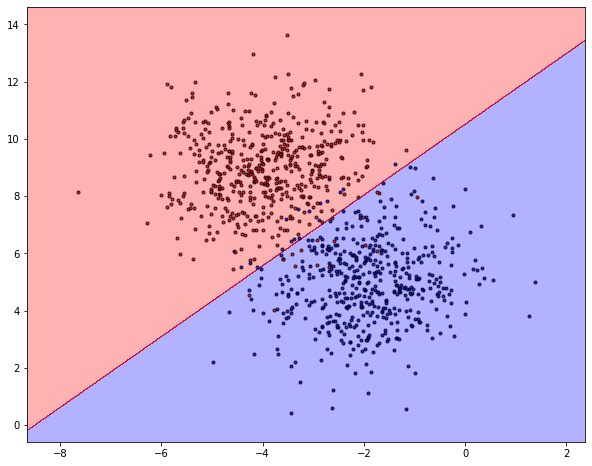

In [87]:
#### Your code here ####

train_X, train_y = X_training[:1000, :], y_training[:1000]
test_X, test_y = X_test[:500, :], y_test[:500]

LoR = LogisticRegressionGD(eta = bestCombo[0], eps = bestCombo[1])
LoR.fit(train_X, train_y)

NB = NaiveBayesGaussian(k=2)
NB.fit(train_X, train_y)

print("Logistic Regression: (1000 training data points, 500 test set data points)")
print("Training accuracy: {}%\nTest accuracy: {}%".format(100*LoR.get_accuracy(train_X, train_y), 100*LoR.get_accuracy(test_X, test_y)))
print("\nNaive Bayes: (1000 training data points, 500 test set data points)")
print("Training accuracy: {}%\nTest accuracy: {}%".format(100*NB.get_accuracy(train_X, train_y), 100*NB.get_accuracy(test_X, test_y)))

print("\n\nLinear regression decision regions: \n(1000 training data points, 500 test set data points)")
plot_decision_regions(train_X, train_y, LoR)

Naive bayes decision regions: 
(1000 training data points, 500 test set data points)


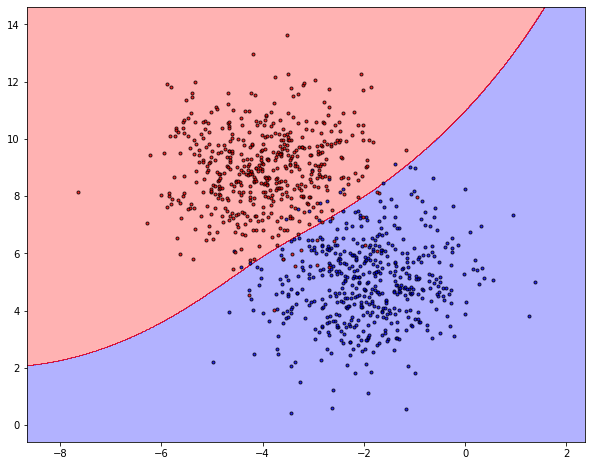

In [88]:
print("Naive bayes decision regions: \n(1000 training data points, 500 test set data points)")
plot_decision_regions(train_X, train_y , NB)
# plot_decision_regions(X_test[:1000,:], y_test[:1000] , NB)

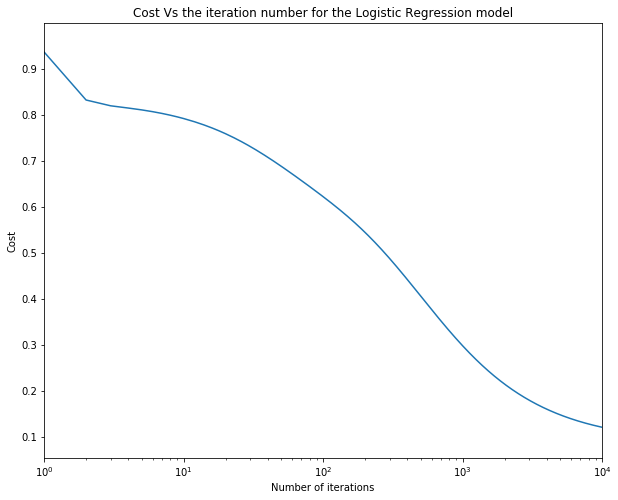

In [89]:
plt.plot(np.arange(len(LoR.J_history)), LoR.J_history)
plt.xscale('log')
plt.xlim(1,10000)
plt.ylim(top=1.0)
plt.yticks(ticks = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
plt.xlabel('Number of iterations')
plt.ylabel('Cost')
plt.title('Cost Vs the iteration number for the Logistic Regression model')

plt.show()

Logistic Regression: (Full training and test sets)
Training accuracy: 80.9%
Test accuracy: 80.4%

Naive Bayes: (1000 training data points, 500 test set data points)
Training accuracy: 92.15%
Test accuracy: 90.10000000000001%


Linear regression decision regions: 
(Full training and test sets)


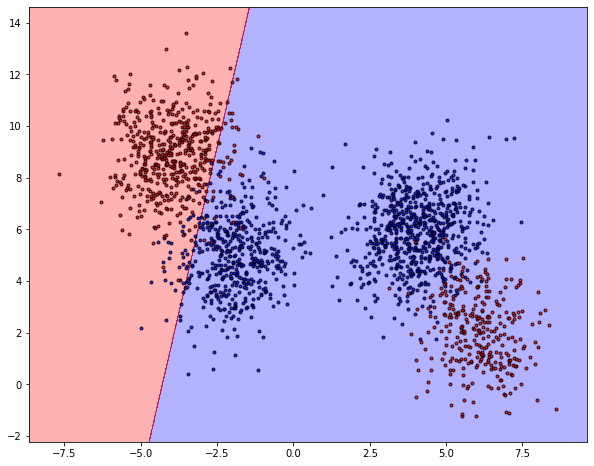

In [90]:
#### Your code here ####
LoR = LogisticRegressionGD(eta = bestCombo[0], eps = bestCombo[1])
NB = NaiveBayesGaussian(k=2)
LoR.fit(X_training, y_training)
NB.fit(X_training, y_training)
print("Logistic Regression: (Full training and test sets)")
print("Training accuracy: {}%\nTest accuracy: {}%".format(100*LoR.get_accuracy(X_training, y_training), 100*LoR.get_accuracy(X_test, y_test)))
print("\nNaive Bayes: (1000 training data points, 500 test set data points)")
print("Training accuracy: {}%\nTest accuracy: {}%".format(100*NB.get_accuracy(X_training, y_training), 100*NB.get_accuracy(X_test, y_test)))

print("\n\nLinear regression decision regions: \n(Full training and test sets)")
plot_decision_regions(X_training, y_training, LoR)

Naive bayes decision regions: 
(Full training and test sets)


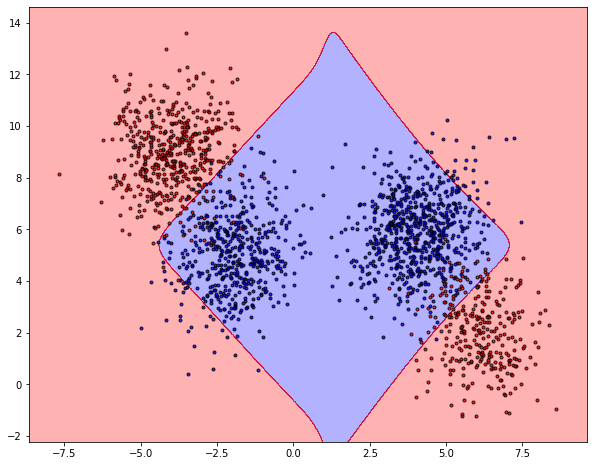

In [91]:
print("Naive bayes decision regions: \n(Full training and test sets)")
plot_decision_regions(X_training, y_training, NB)

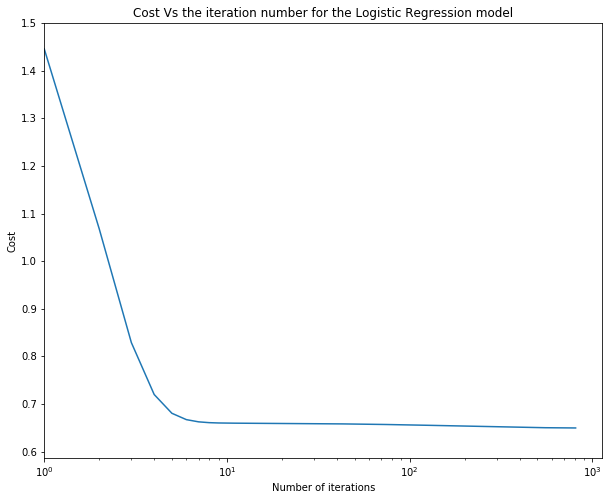

In [92]:
plt.plot(np.arange(len(LoR.J_history)), LoR.J_history)
plt.xscale('log')
plt.xlabel('Number of iterations')
plt.xlim(1)
plt.ylim(top=1.5)
plt.yticks(ticks=[0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5])
plt.ylabel('Cost')
plt.title('Cost Vs the iteration number for the Logistic Regression model')
plt.show()

## Open question

(7 points) 

Will Full Bayes get better results comparing to Naive Bayes on the following dataset? Explain. 

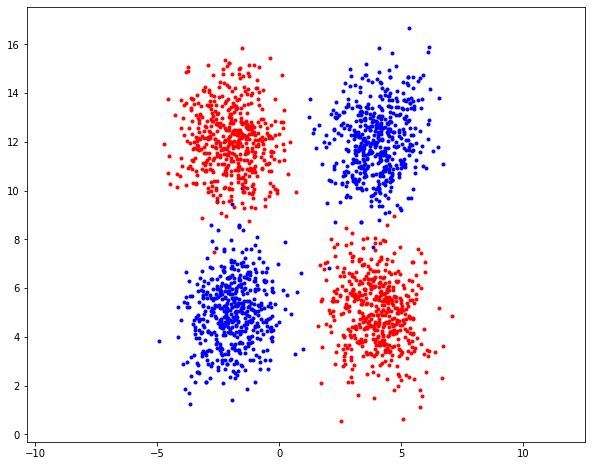

In [93]:
mean = [[-2,5], [-2, 12], [4, 12], [4, 5]]
cov = [[[1,0.2],[0.2,2]], [[1,0],[0,2]], [[1,0.2],[0.2,2]], [[1,-0.2],[-0.2,2]]]
x1 = []
x2 = []
y = []
size = [500, 500, 500, 500]
c = ['b', 'r']
for i in range(4):
    xx1,xx2 = np.random.multivariate_normal(mean[i],cov[i],size[i]).T
    x1.extend(xx1)
    x2.extend(xx2)
    y.extend([i%2] * size[i])
    plt.scatter(xx1,xx2, marker='.', c=c[i%2])
plt.axis('equal')
plt.show()

#### Your answer here ####


In this data we can see not only that for every feature the data split into half (aprox.) that belongs to one class and half to the other.
While the full bayes "see" the data like the graph above and can distinguish, 
the naive base assumes the features are independent given the class.
This assumption will "flatten" the above graph into 1-D graph, where the red and blue dots will be one on top of the other-
meaing no seperating of data will be possible, and only 50% of the guessing (predictions) will be correct.
